# Visualizing Data and Training Models

In this notebook, we'll use a cardiovascular disease data set that contains standard health information and information on the presence/absence of cardiovascular disease for over 70,000 patients. We are going to visualize the data, clean the data, and train machine learning models for classifying whether an individual is at risk of cardiovascular disease, and save the most performant model for future use.

Let’s begin by importing all the libraries that we’ll need in order to run this notebook.

In [ ]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import layers, models
import pickle

## Obtain Data

Run the following cell to read the cardiovascular disease data set into Python as a `pandas` data frame called `df`.

In [ ]:
url = "https://raw.githubusercontent.com/M-0-N-I-C-A/PIC16B_Project/main/data/cardio_train.csv"
df = pd.read_csv(url, sep = ';')

In [ ]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Exploring Our Data Set

We want to have a basic understanding of this data set through the plots below. 

Let's start by creating a heatmap. 

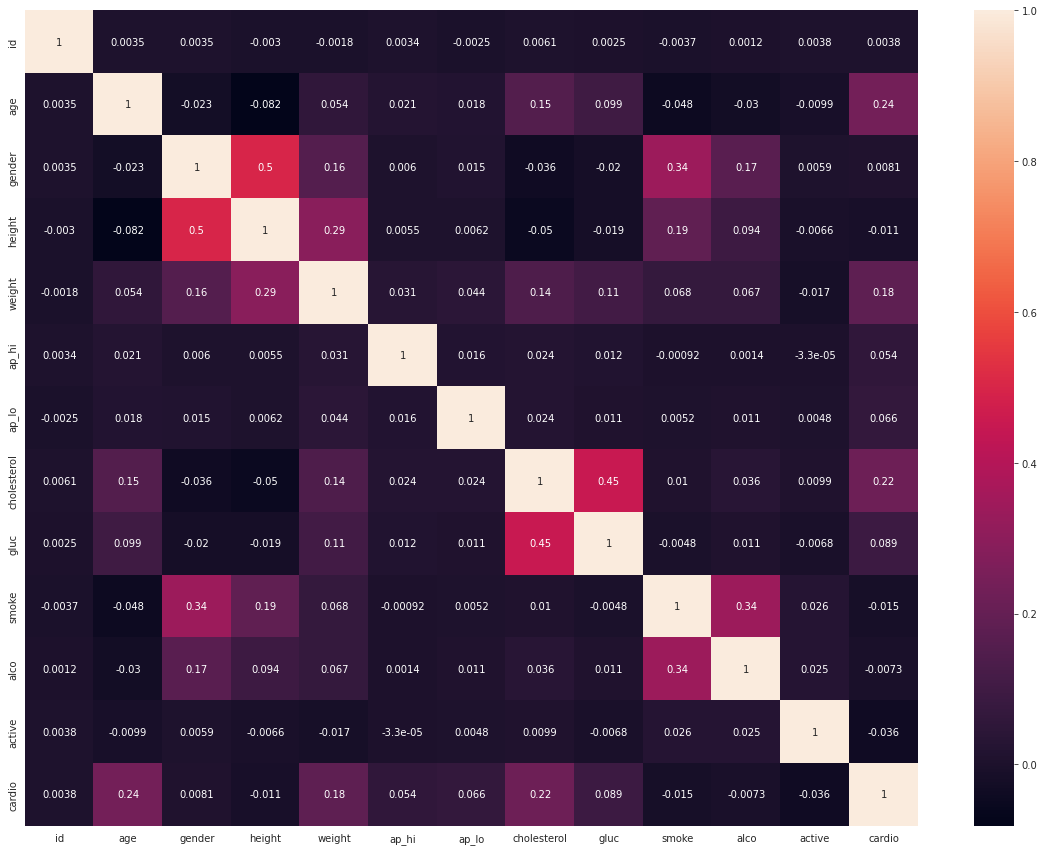

In [ ]:
# check correlations
plt.figure(figsize = (20, 15))
fgrid = sns.heatmap(df.corr(), annot = True)

This heatmap shows correlations between different variables in the data set. 
We see that no features directly correlate with the `cardio` column and generally, there do not exist significant correlations between other variables. However, correlations exist between the following variables:

- `height` and `gender` columns are correlated with a score of 0.5.
- `gluc` and `cholesterol` columns are correlated with a score of 0.45.
- `smoke` and `gender` columns are correlated with a score of 0.34.

Now we'll write a function to create a box-and-whisker plot.

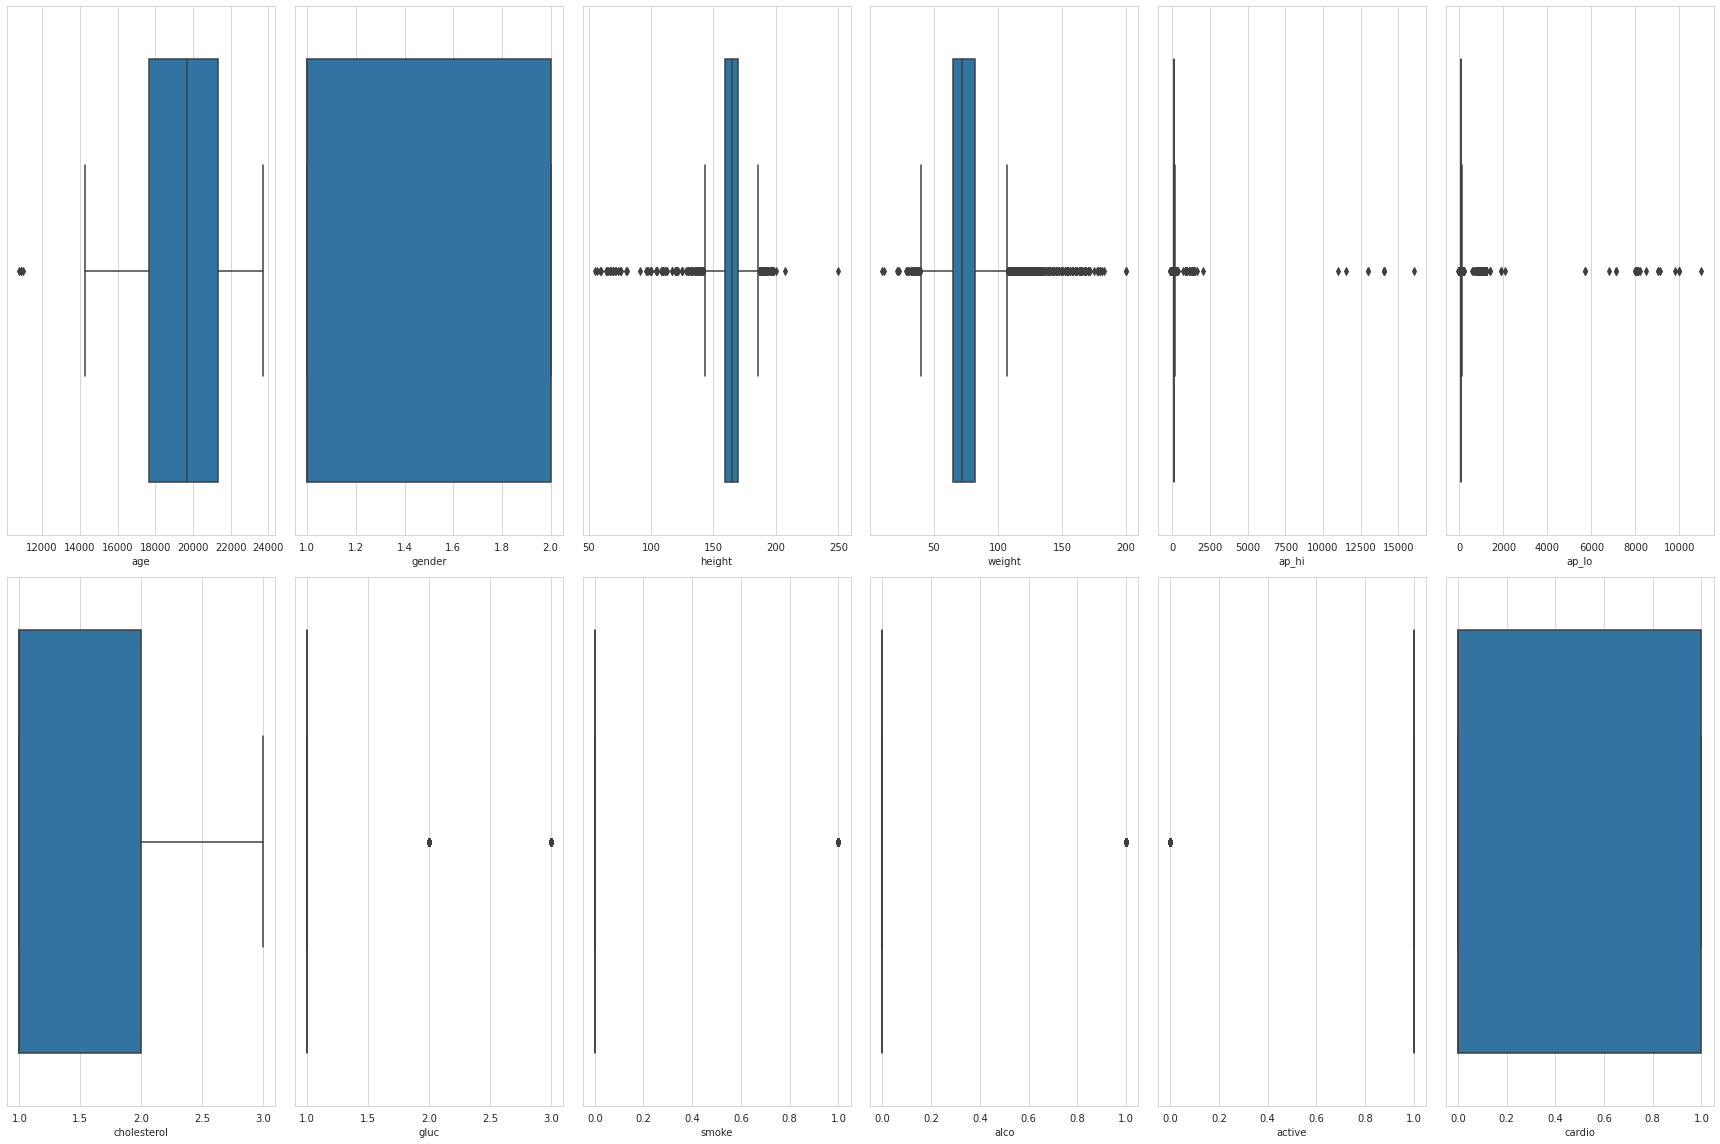

In [ ]:
# check outliers
def check_outliers(df):
    """
    Check outliers in the data set. 

    Parameters
    ----------
    df: pd.DataFrame(), the data set in which outliers are checked

    Return
    ----------
    No return value
    """

    l = df.columns.values
    number_of_columns = (len(l) - 1) / 2
    number_of_rows = 2
    
    # create a figure
    plt.figure(figsize = (4 * number_of_columns, 8 * number_of_rows))

    # loop over the columns in the data set
    for i in range(1, len(l)):
        # add a subplot in a grid with 2 rows and 6 columns in position i
        ax = plt.subplot(number_of_rows, number_of_columns, i)

        sns.set_style('whitegrid')
        sns.boxplot(x = df[l[i]])

        # stretch the plots so that they don't look "squished"
        plt.tight_layout()


check_outliers(df) # demonstration

As we can see, there are outliers in the data set in the `ap_hi` and `ap_lo` columns. These outliers may be explained by human error when entering the data into the `csv` file. Removing these outliers might improve the accuracy of our model.

Next, we want to write a function to create a kernel density estimate (KDE) plot.

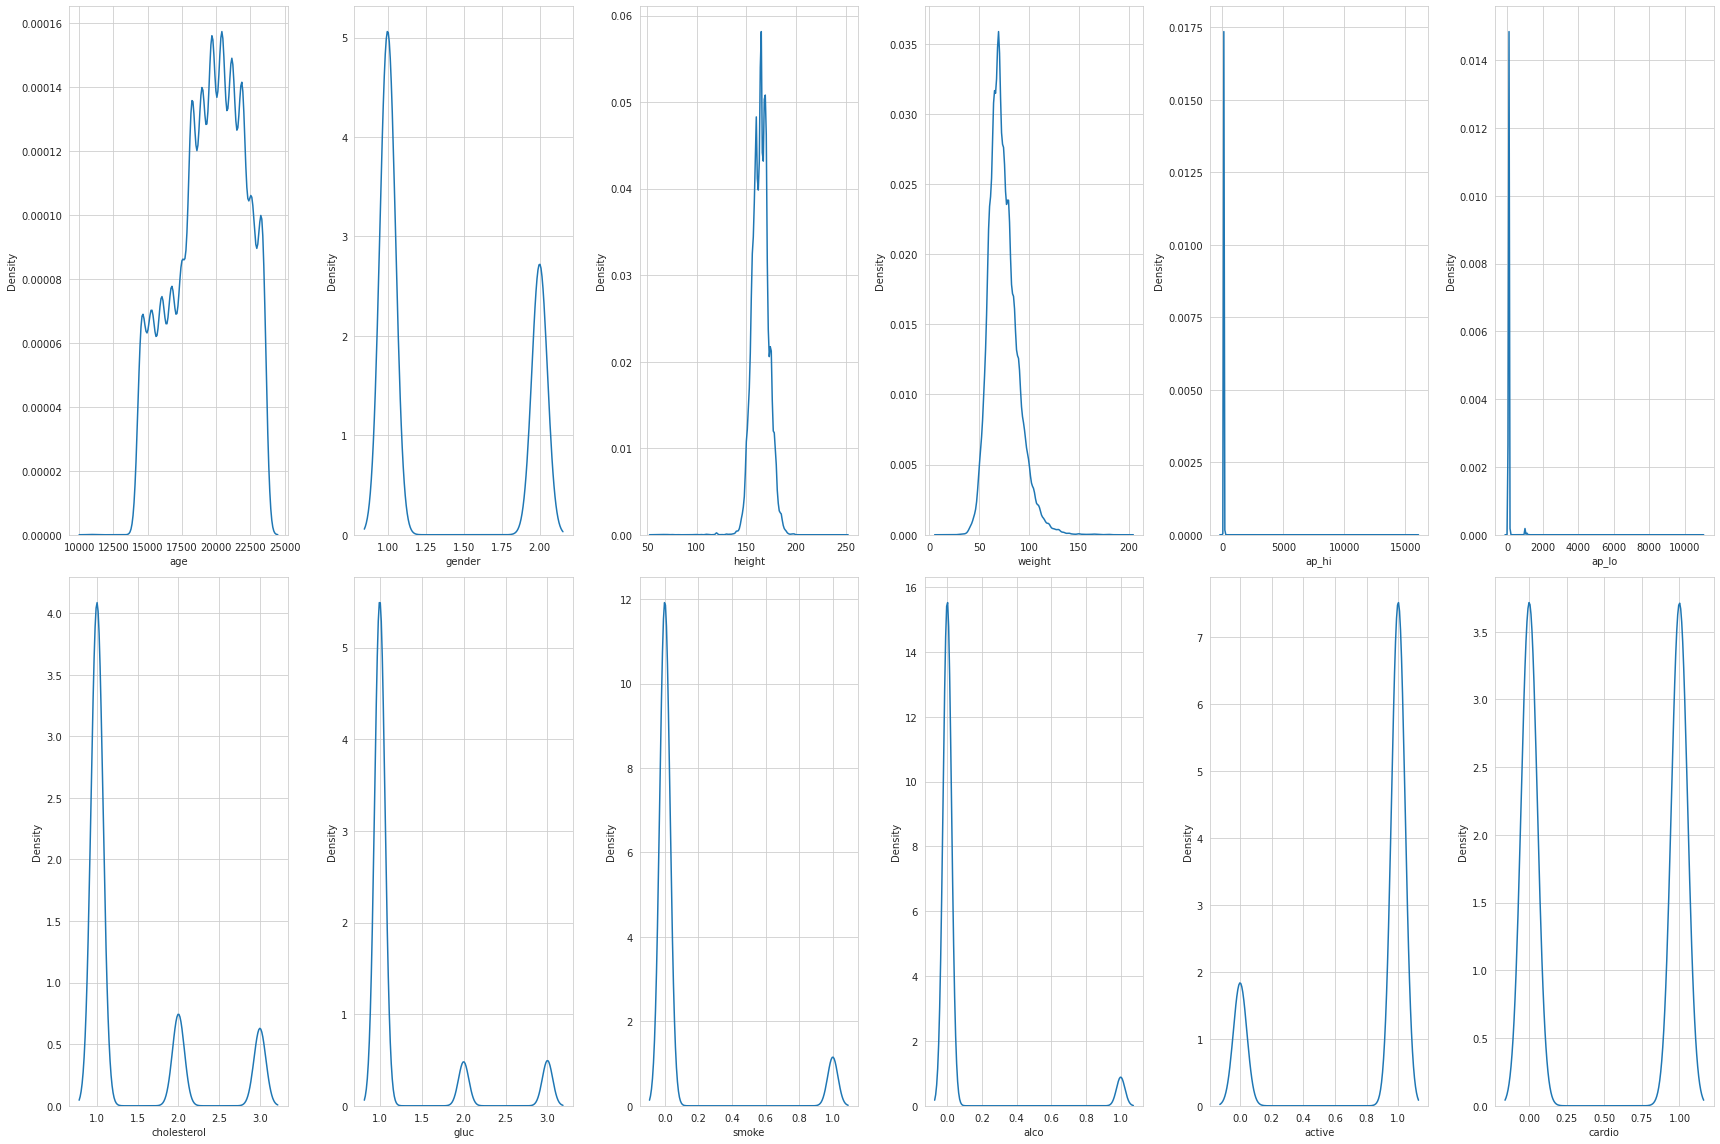

In [ ]:
# check distribution
def check_dist(df):
    """
    Check the distribution of each variable in the data set.

    Parameters
    ----------
    df: pd.DataFrame(), the data set in which the distribution of each variable is checked

    Return
    ----------
    No return value
    """

    l = df.columns.values
    number_of_columns = (len(l) - 1) / 2
    number_of_rows = 2
    
    # create a figure
    plt.figure(figsize = (4 * number_of_columns, 8 * number_of_rows))

    # loop over the columns in the data set
    for i in range(1, len(l)):
        # add a subplot in a grid with 2 rows and 6 columns in position i
        plt.subplot(number_of_rows, number_of_columns, i)

        sns.set_style('whitegrid')
        sns.kdeplot(x = df[l[i]]) 

        # stretch the plots so that they don't look "squished"
        plt.tight_layout()
        
check_dist(df) # demonstration

As we can see, the `height` and `weight` columns are roughly normally distributed, but there are some variations in the `age` column. This plot further suggests the presence of outliers in the `ap_hi` and `ap_lo` columns. Also, there exist categorical variables in the data set: the `gender`, `cholesterol`, `gluc`, `smoke`, `alco`, and `active` columns.

## Clear and Transform Our Data

We'll remove outliers in the `ap_hi` and `ap_lo` columns. Only values less than 250 will be kept in the data set.

In [ ]:
# remove outliers in the ap_hi and ap_lo columns
df = df[df['ap_hi'] < 250]  
df = df[df['ap_lo'] < 250]

Let's plot the data again.

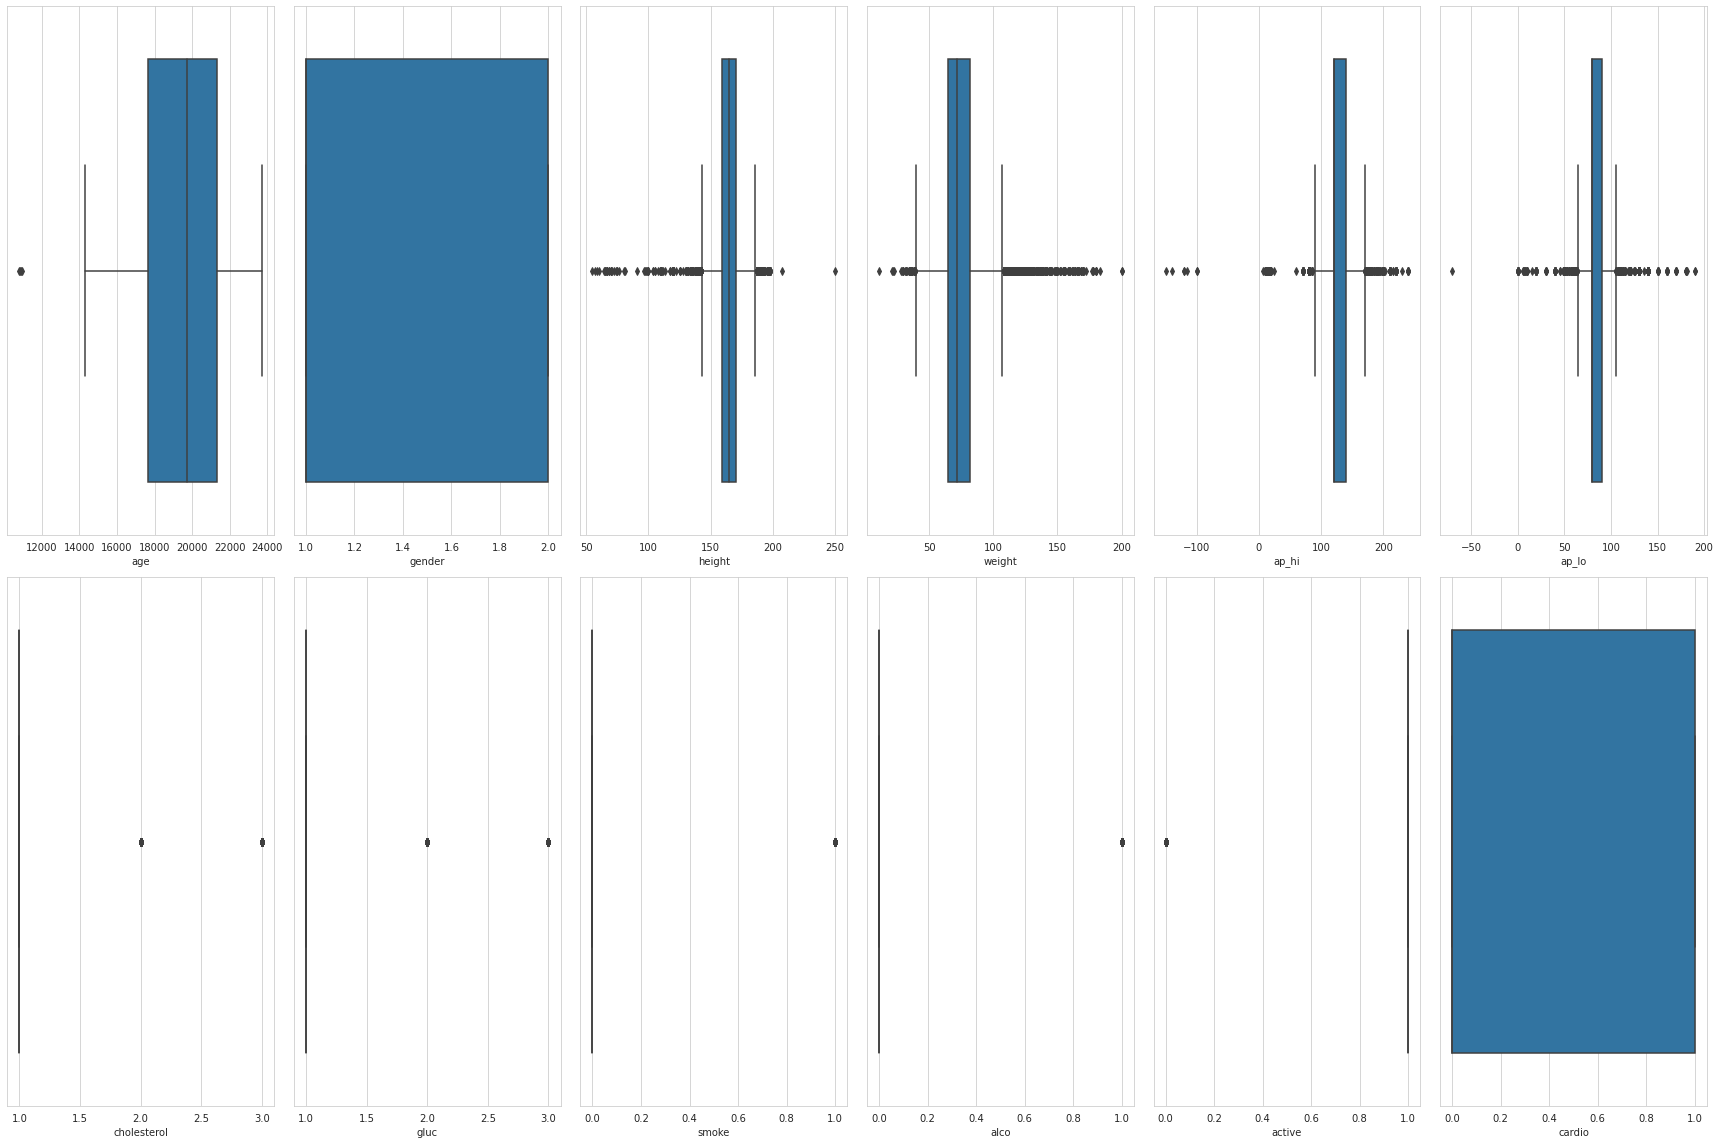

In [ ]:
check_outliers(df) # demonstration

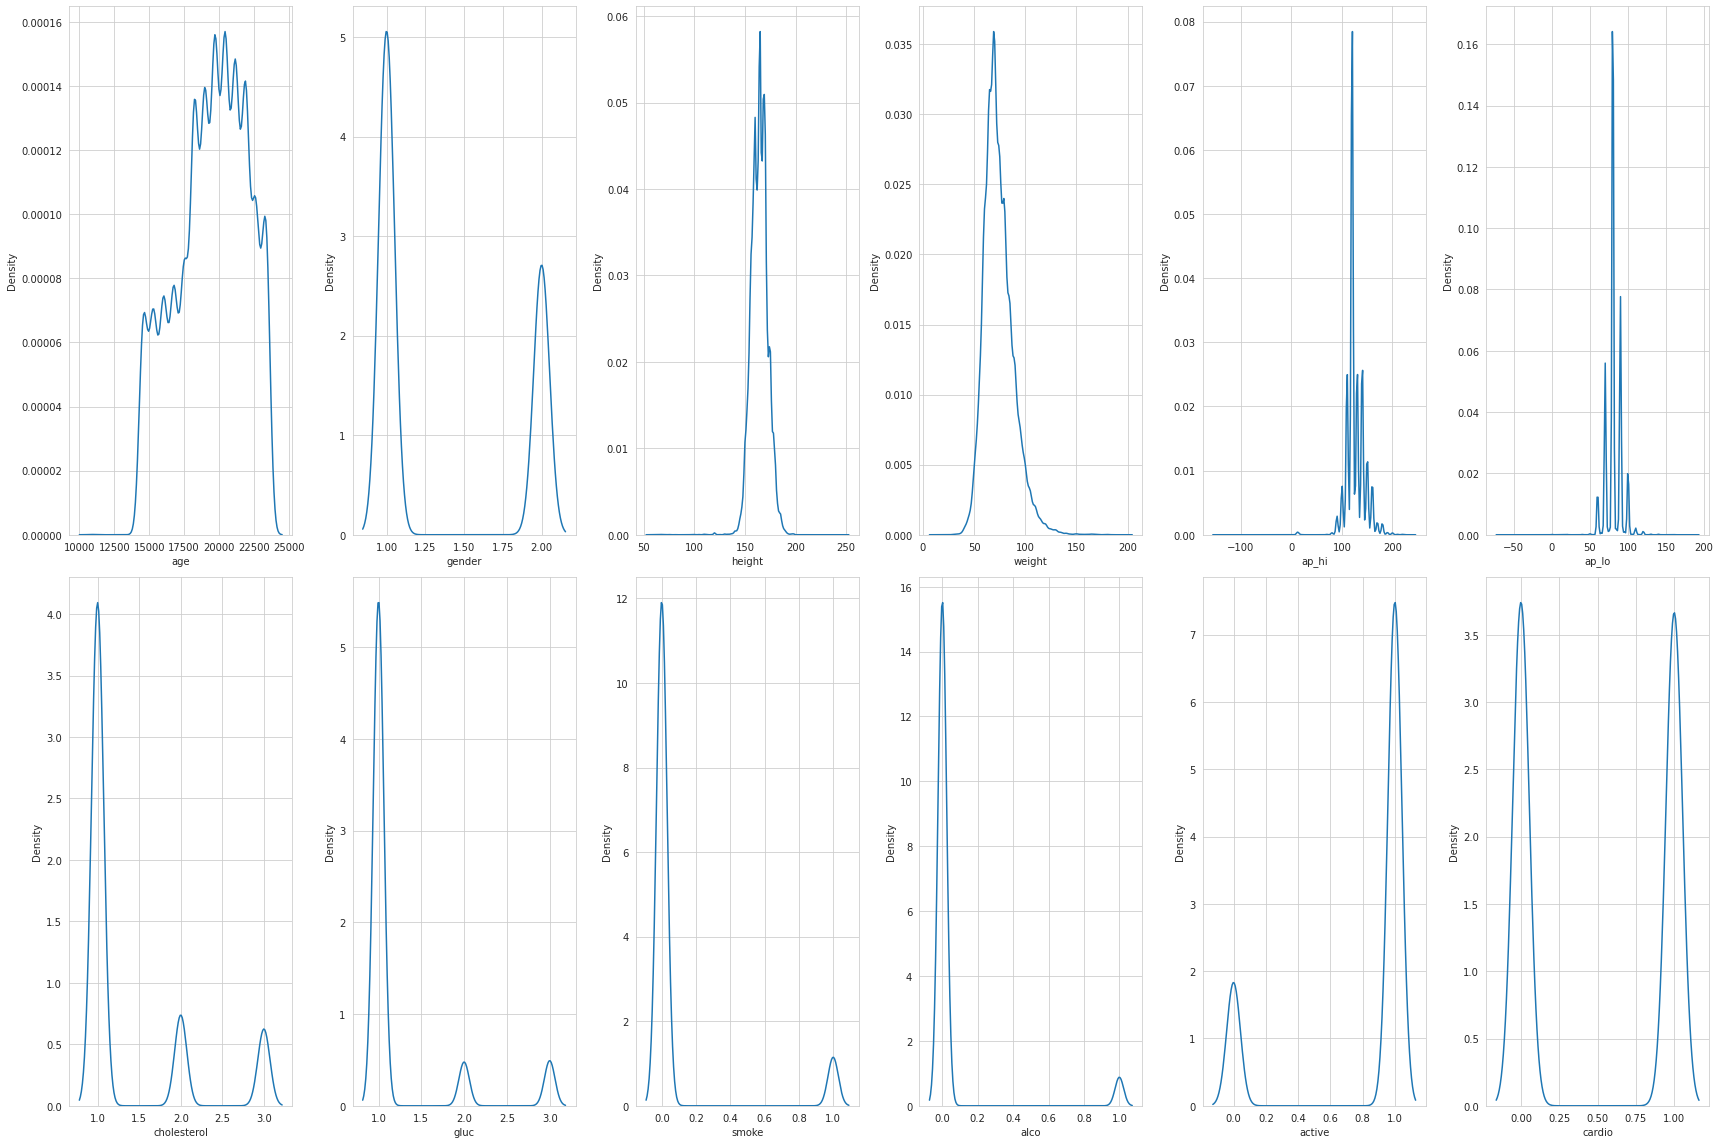

In [ ]:
check_dist(df) # demonstration

Now the `ap_hi` and `ap_lo` columns are roughly normally distributed. This will allow the data set to provide more reliable input for our model.

Let's further clean the data as follows:

- convert the `gender` column in the data frame to 0 or 1

- convert the `age` column in the data frame to years

- remove the `id` column that we don't use from the data frame

In [ ]:
# convert 1/2 to 0/1
df["gender"] = df["gender"] - 1
# convert days to years
df["age"] = df["age"] // 365
# remove the id column from df
df = df.drop(["id"], axis = 1)

In [ ]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168,62.0,110,80,1,1,0,0,1,0
1,55,0,156,85.0,140,90,3,1,0,0,1,1
2,51,0,165,64.0,130,70,3,1,0,0,0,1
3,48,1,169,82.0,150,100,1,1,0,0,1,1
4,47,0,156,56.0,100,60,1,1,0,0,0,0


## Check Label Frequencies

Let’s compute the number of rows in the data set with the `cardio` column equal to `0` (corresponding to the absence of cardiovascular disease) and the number of rows in the data set with the `cardio` column equal to `1`(corresponding to the presence of the disease).

In [ ]:
presence_count = sum(df["cardio"] == 1)
absence_count = sum(df["cardio"] == 0)

# show the numbers
presence_count, absence_count

(34150, 34857)

The *baseline* machine learning model is the model that always guesses the most frequent label. In our case, there is an about equal number of rows in the data set with the `cardio` column equal to 0 and the `cardio` column equal to 1. So, the accuracy of the baseline model would be close to 50%.

We’ll treat this as the benchmark for improvement. Our models should do much better than this baseline model in order to be considered good data science achievements!

## Model Based on Heatmap

Let’s create a `tf.keras.models.Sequential` model using `Dense` layers.

We'll first separate the cleaned data set into predictor data consisting of the five columns with the highest correlation scores based on the above heatmap and target data, which is the `cardio` column. Then we split the data set into training (70%) and test (30%) data. 

In [ ]:
# predictor data
X = df[["age", "cholesterol", "weight", "gluc", "ap_lo"]]
# target data
y = df["cardio"]

# hold out 30% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
# create a model
model1 = models.Sequential([
    layers.Dense(500, activation='relu',input_shape=(5,)),
    layers.Dense(500, activation='relu'),
    layers.Dense(2)
])

Now we can use the `model.summary()` to inspect our model.

In [ ]:
# show the summary
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 500)               3000      
                                                                 
 dense_13 (Dense)            (None, 500)               250500    
                                                                 
 dense_14 (Dense)            (None, 2)                 1002      
                                                                 
Total params: 254,502
Trainable params: 254,502
Non-trainable params: 0
_________________________________________________________________


Let’s train our model for 20 epochs and see how it does.

In [ ]:
# compile the model
model1.compile(optimizer = "adam",
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = ["accuracy"])

In [ ]:
# fit our model
history = model1.fit(X_train, y_train, epochs = 20, verbose=1)

Epoch 1/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.7572 - accuracy: 0.5359
Epoch 2/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6712 - accuracy: 0.5820
Epoch 3/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6491 - accuracy: 0.6233
Epoch 4/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6255 - accuracy: 0.6577
Epoch 5/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6095 - accuracy: 0.6733
Epoch 6/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6026 - accuracy: 0.6824
Epoch 7/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.6005 - accuracy: 0.6840
Epoch 8/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5981 - accuracy: 0.6860
Epoch 9/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5957 - accuracy: 0.6890
Epoch 10/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.595

Next, we’ll visualize the training history.

[Text(0, 0.5, 'training accuracy'), Text(0.5, 0, 'epoch')]

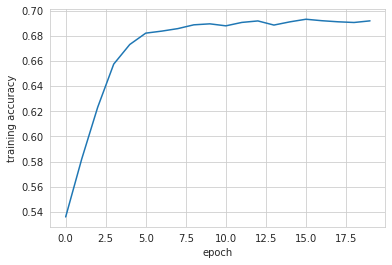

In [ ]:
# plot the history of the accuracy on the training set
plt.plot(history.history["accuracy"])
# label the axes
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

Notice that the training accuracy of our model at the end is 69%. We do better than the baseline model.

Let’s evaluate the accuracy of this model on the unseen test data set.

In [ ]:
# evaluate model1 on the test data set
loss, accuracy = model1.evaluate(X_test, y_test)
accuracy

647/647 [==============================] - 2s 2ms/step - loss: 0.5924 - accuracy: 0.6913


0.6913007497787476

`model1` can achieve 69% accuracy on the test set.

## Model with All Columns

Let’s again create a `tf.keras.models.Sequential` model using `Dense` layers.

The predictor data now contains all of the  columns in the data set except the `cardio` column, which is the target data.

In [ ]:
# predictor data
X = df.drop(["cardio"], axis = 1)
# target data
y = df[["cardio"]]

# hold out 30% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
# create a model
model2 = models.Sequential([
    layers.Dense(500, activation='relu',input_shape=(11,)),
    layers.Dense(500, activation='relu'),
    layers.Dense(2)
])

Now we can use the `model.summary()` to inspect our model.

In [ ]:
# show the summary
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 500)               6000      
                                                                 
 dense_34 (Dense)            (None, 500)               250500    
                                                                 
 dense_35 (Dense)            (None, 2)                 1002      
                                                                 
Total params: 257,502
Trainable params: 257,502
Non-trainable params: 0
_________________________________________________________________


Let’s train our model for 20 epochs and see how it does.

In [ ]:
# compile our model
model2.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ["accuracy"])

In [ ]:
# fit our model
history = model2.fit(X_train, y_train, epochs = 20, verbose=1)

Epoch 1/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.8704 - accuracy: 0.6461
Epoch 2/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5930 - accuracy: 0.6961
Epoch 3/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5795 - accuracy: 0.7023
Epoch 4/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5728 - accuracy: 0.7119
Epoch 5/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5739 - accuracy: 0.7094
Epoch 6/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5713 - accuracy: 0.7112
Epoch 7/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5705 - accuracy: 0.7132
Epoch 8/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5684 - accuracy: 0.7129
Epoch 9/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.5678 - accuracy: 0.7138
Epoch 10/20
1510/1510 [==============================] - 8s 5ms/step - loss: 0.566

Next, we’ll visualize the training history.

[Text(0, 0.5, 'training accuracy'), Text(0.5, 0, 'epoch')]

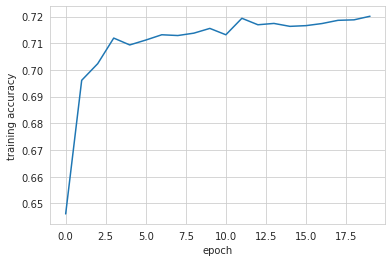

In [ ]:
# plot the history of the accuracy on the training set
plt.plot(history.history["accuracy"], label = "training")
# label the axes
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

Notice that the training accuracy of our model at the end is 72%. We do better than the baseline model.

Let’s evaluate the accuracy of this model on the unseen test data set.

In [ ]:
# evaluate model2 on the test data set
loss, accuracy = model2.evaluate(X_test, y_test)
accuracy

647/647 [==============================] - 2s 2ms/step - loss: 0.5615 - accuracy: 0.7216


0.721634566783905

`model2` can achieve 72% accuracy on the test set.

## Multinomial Logistic Regression Model

It is challenging to pickle TensorFlow models. With the aim of incorporating a model into our webapp, we now want to train a logistic regression model. We'll use this model if its accuracy is higher than the above TensorFlow models.

Similarly, we'll first separate the cleaned data set into predictor data and target data, which is the `cardio` column. Since the accuracy of `model2` is higher than the accuracy of `model1`, we're going to use the same predictor data consisting of all of the columns in the data set except the `cardio` column as in `model2`. Then we split the data set into training (70%) and test (30%) data.

In [ ]:
# predictor data
X = df.drop(["cardio"], axis = 1)
# target data
y = df["cardio"]

# hold out 30% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
model3 = LogisticRegression(random_state = 0, solver = "liblinear")

In [ ]:
# fit our model
model3.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

Let’s evaluate the accuracy of this model on the unseen test data set.

In [ ]:
# evaluate model3 on the test data set
model3.score(X_test, y_test)

0.7316813988310873

Great! This logistic regression model can ahieve 73% on the test set. This accuracy is higher than the accuracy of `model1` and the accuracy of `model2`. We'll choose to use this logistic regression model in our webapp.

## Pickling

We are going to pickle `model3` so that we can save the model and use it in our webapp. We pickle the model by calling `pickle.dump` with an open file connection.

In [ ]:
filename = 'cardio-model/model.pkl'
pickle.dump(model3, open(filename, 'wb'))